In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import shap

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', 1000)
pd.options.display.float_format = '{:.4f}'.format
sns.set()

In [60]:
# load dataset
df = pd.read_csv("bike.csv")
df.head(3)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,SPRING,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.1758,80.5833,10.7499,985,0
1,SPRING,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.0835,69.6087,16.6521,801,1
2,SPRING,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.2291,43.7273,16.6367,1349,2


In [61]:
# dummy encode categorical columns
df = pd.get_dummies(data=df)
df.head(3)

,yr,temp,hum,windspeed,cnt,days_since_2011,season_FALL,season_SPRING,season_SUMMER,season_WINTER,mnth_APR,mnth_AUG,mnth_DEC,mnth_FEB,mnth_JAN,mnth_JUL,mnth_JUN,mnth_MAR,mnth_MAY,mnth_NOV,mnth_OCT,mnth_SEP,holiday_HOLIDAY,holiday_NO HOLIDAY,weekday_FRI,weekday_MON,weekday_SAT,weekday_SUN,weekday_THU,weekday_TUE,weekday_WED,workingday_NO WORKING DAY,workingday_WORKING DAY,weathersit_GOOD,weathersit_MISTY,weathersit_RAIN/SNOW/STORM
0,2011,8.1758,80.5833,10.7499,985,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0
1,2011,9.0835,69.6087,16.6521,801,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0
2,2011,1.2291,43.7273,16.6367,1349,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0


In [62]:
# train simple model
y = df['cnt']
x = df.drop('cnt', axis=1)

rf = RandomForestRegressor(random_state=42, n_estimators=50, n_jobs=-1,max_depth=7)
rf.fit(x, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

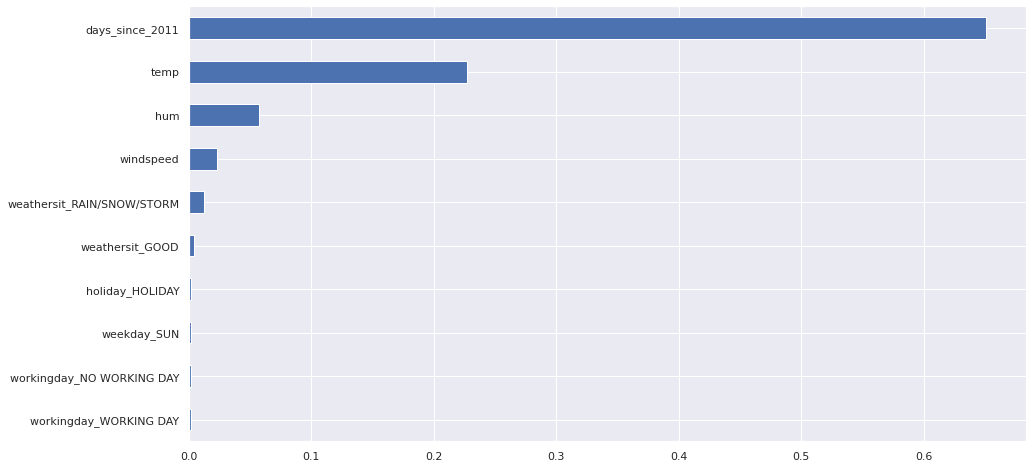

In [63]:
feat_importances = pd.Series(rf.feature_importances_, index=x.columns)
feat_importances.sort_values(ascending=True).tail(10).plot(kind='barh',figsize=(15,8)) 

In [64]:
feat_importances.sum()

1.0

In [65]:
# check rmse
predict = rf.predict(x)
mean_squared_error(y, predict,squared=False)

435.8448949803755

In [66]:
# create SHAP explainer
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(x)

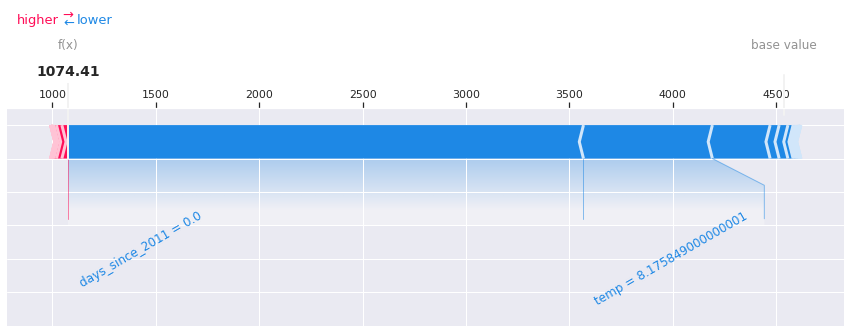

In [67]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], x.iloc[0,:], matplotlib=True, figsize=(15, 4),text_rotation=30)

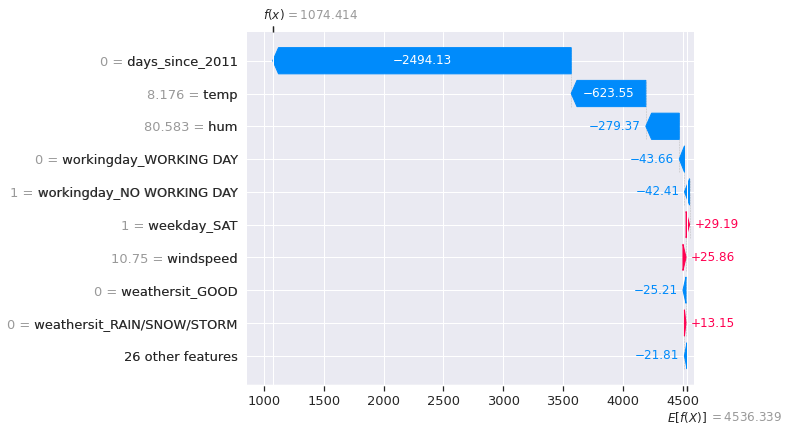

In [68]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0],  shap_values[0,:], x.iloc[0,:])

In [69]:
shap_vals = shap_values[0, :]
feature_importance = pd.DataFrame(list(zip(x.columns, shap_vals)), columns=['column_value','shap_vals'])
feature_importance.sort_values(by=['shap_vals'], ascending=False,inplace=True)
feature_importance

,column_value,shap_vals
25,weekday_SAT,29.1924
3,windspeed,25.8622
34,weathersit_RAIN/SNOW/STORM,13.1481
26,weekday_SUN,5.7439
11,mnth_DEC,2.7776
21,holiday_HOLIDAY,2.5301
17,mnth_MAY,0.9175
29,weekday_WED,0.8996
19,mnth_OCT,0.7169
24,weekday_MON,0.4902


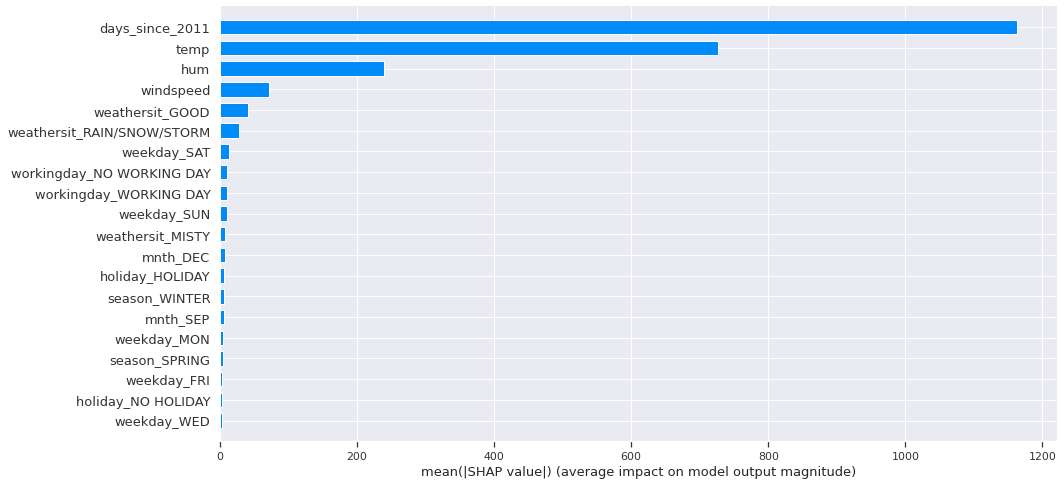

In [70]:
# Plot the features'average impact on the model output's magnitude
shap.summary_plot(shap_values, x, plot_type="bar",plot_size=(15,8))

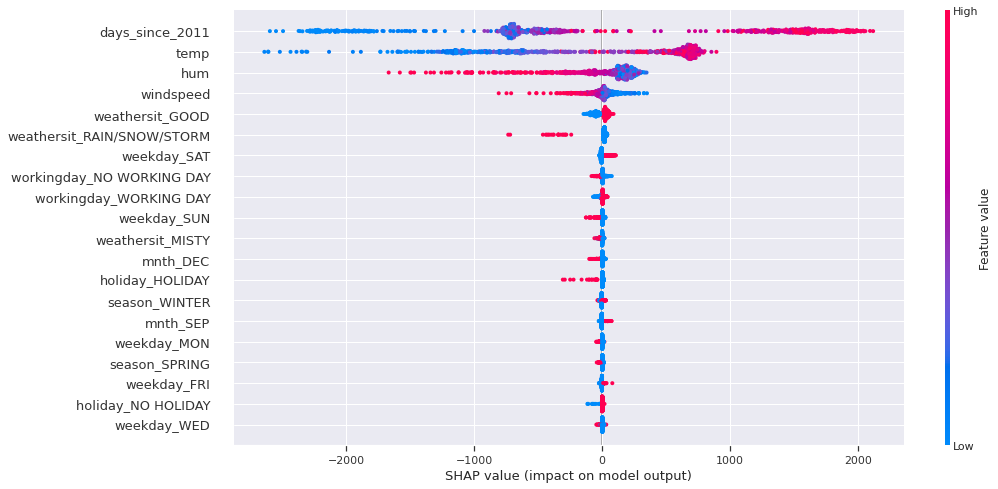

In [71]:
# combine feature importance with feature effects
shap.summary_plot(shap_values, x, plot_size=(15,8))

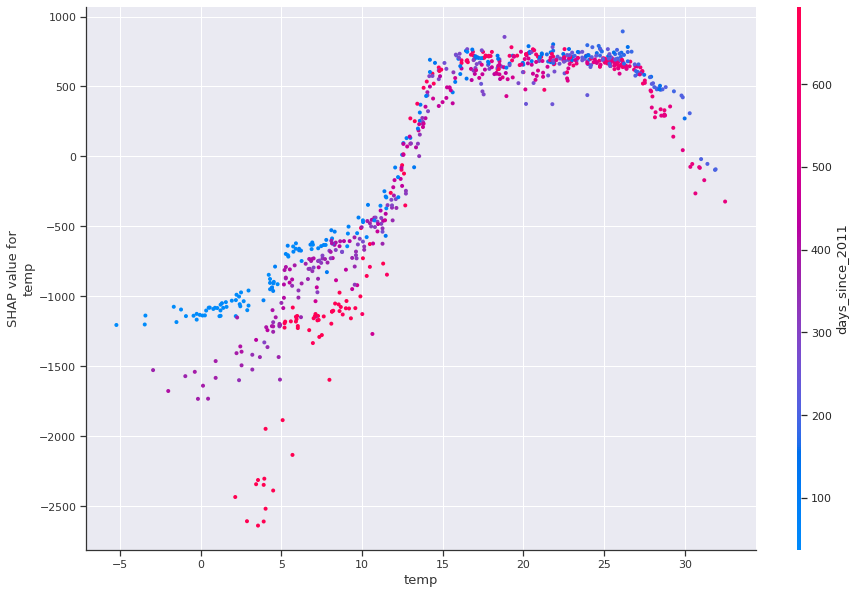

In [72]:
# dependency plot for temp
fig, ax = plt.subplots(figsize=(15,10))
shap.dependence_plot('temp', shap_values, x,ax=ax)